In [3]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import pyro.infer
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


import time

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [4]:
df = pd.read_pickle('merged_df_DK2.pkl')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df=df.drop('HourUTC', axis=1)
df=df.drop('PriceArea', axis=1)
df.columns

Index(['HourDK', 'Wind', 'Hydro', 'Solar', 'Power', 'Unknown_Production',
       'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh', 'Exchange', 'GridLoss',
       'SpotPriceDKK', 'SpotPriceEUR', 'hourly_temperature_2m',
       'precipitation', 'cloud_cover', 'hourly_wind_speed_10m'],
      dtype='object')

In [5]:
df_use=df[['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh',
       'SpotPriceDKK', 'hourly_temperature_2m',
       'cloud_cover', 'hourly_wind_speed_10m']]
df_use
#'Hydro','Unknown_Production',
       # 'ExchangeGreatBelt_MWh', 'Exchange', 'GridLoss' , 'SpotPriceEUR', 'precipitation', 

,HourDK,Wind,Solar,Power,GrossConsumptionMWh,SpotPriceDKK,hourly_temperature_2m,cloud_cover,hourly_wind_speed_10m
1,2022-01-01 00:00:00,1114.281163,0.022679,789.892353,1415.517875,346.540009,7.0,100,4.14
3,2022-01-01 01:00:00,1206.825676,0.022142,644.458331,1394.053760,307.350006,7.4,100,4.10
5,2022-01-01 02:00:00,1215.685368,0.020423,599.437590,1342.593361,313.670013,6.9,100,3.98
7,2022-01-01 03:00:00,1070.803483,0.024189,624.804126,1292.604709,329.959991,6.6,100,3.57
9,2022-01-01 04:00:00,899.497269,0.019869,650.523492,1261.550580,280.130005,6.7,100,3.01
...,...,...,...,...,...,...,...,...,...
37911,2024-02-29 19:00:00,1269.406780,0.603984,692.384290,1950.231822,402.510010,7.0,100,4.73
37913,2024-02-29 20:00:00,1295.941996,0.462586,699.232854,1856.984338,216.910004,6.8,100,4.74
37915,2024-02-29 21:00:00,1279.730675,0.429421,669.755253,1767.729341,186.720001,6.5,100,4.84
37916,2024-02-29 22:00:00,1233.604793,0.437171,605.839292,1654.056866,186.720001,6.5,100,4.82


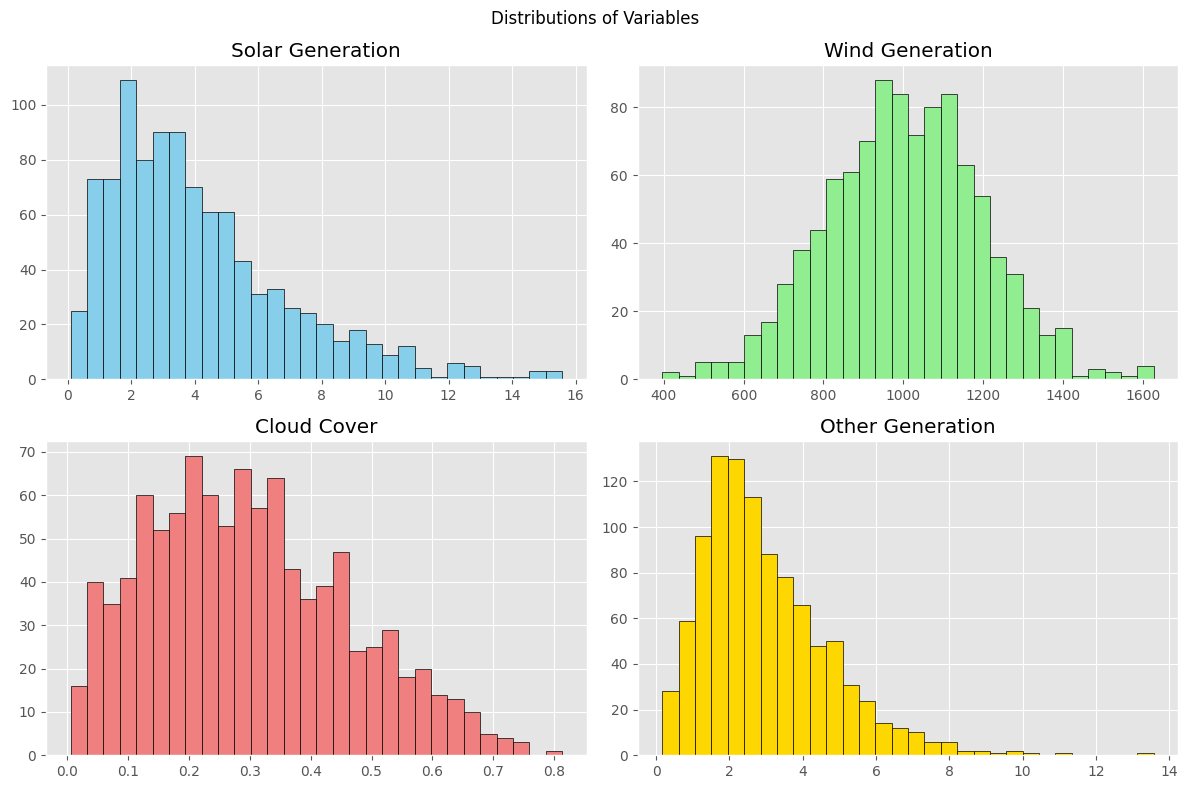

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data for each variable (replace these with your actual data)
num_samples = 1000

# Sample data for Solar Generation (Gamma distribution)
solar_shape = 2.0
solar_rate = 0.5
solar_samples = np.random.gamma(solar_shape, 1.0 / solar_rate, size=num_samples)

# Sample data for Wind Generation (Normal distribution)
wind_mean = 1000.0
wind_std = 200.0
wind_samples = np.random.normal(wind_mean, wind_std, size=num_samples)

# Sample data for Cloud Cover (Beta distribution)
cloud_alpha = 2.0
cloud_beta = 5.0
cloud_samples = np.random.beta(cloud_alpha, cloud_beta, size=num_samples)

# Sample data for Other Generation (Gamma distribution)
other_shape = 3.0
other_rate = 1.0
other_samples = np.random.gamma(other_shape, 1.0 / other_rate, size=num_samples)

# Create subplots for each variable
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot histograms for each variable
axs[0, 0].hist(solar_samples, bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Solar Generation')
axs[0, 1].hist(wind_samples, bins=30, color='lightgreen', edgecolor='black')
axs[0, 1].set_title('Wind Generation')
axs[1, 0].hist(cloud_samples, bins=30, color='lightcoral', edgecolor='black')
axs[1, 0].set_title('Cloud Cover')
axs[1, 1].hist(other_samples, bins=30, color='gold', edgecolor='black')
axs[1, 1].set_title('Other Generation')

# Add a title to the figure
fig.suptitle('Distributions of Variables')

# Adjust layout
plt.tight_layout()
plt.show()


In [28]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
import numpyro
import numpyro.distributions as dist

def model(data):
  """
  This model defines a probabilistic relationship between Wind, Solar, Power, 
  and Gross Consumption using a partially directed structure.

  Args:
      data: A dictionary containing observed values for each variable.

  Returns:
      No return value, samples are collected within the model definition.
  """

  # Extract data
  wind = df["Wind"]
  solar = df["Solar"]
  power = df["Power"]

  # Define coefficients (assuming linear relationships for now)
  beta_wind = pyro.sample(name="beta_wind", fn=dist.Normal(loc=0., scale=1.))
  beta_solar = pyro.sample(name="beta_solar", fn=dist.Normal(loc=0., scale=1.))
  beta_power = pyro.sample(name="beta_power", fn=dist.Normal(loc=0., scale=1.))

  # Define a base distribution for gross consumption (can be adjusted based on your findings)
  mu_0 = pyro.param(name="mu_0", default=0.0)  # Base mean
  sigma_0 = pyro.param(name="sigma_0", default=1.0)  # Base standard deviation

  # Model the gross consumption
  gross_consumption = beta_wind * wind + beta_solar * solar + beta_power * power + mu_0
  pyro.sample(
      name="gross_consumption", fn=dist.Normal(loc=gross_consumption, scale=sigma_0), obs=data["GrossConsumptionMWh"]
  )

# Example usage (assuming you have your data loaded in a dictionary named 'data')
model(data)


In [29]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Define train and test indices
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# Define train and test sets
train_data = df.loc[train_idx]
test_data = df.loc[test_idx]

X_train = train_data.drop(columns=['GrossConsumptionMWh'])
y_train = train_data['GrossConsumptionMWh'].values

X_test = test_data.drop(columns=['GrossConsumptionMWh'])
y_test = test_data['GrossConsumptionMWh'].values

# Define guide fuanction
model = EnergyModel(n_in=X_train.shape[1], n_hidden=4, n_out=1) 
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
train_losses = []
for step in range(n_steps):
    elbo = svi.step(torch.tensor(X_train.values, dtype=torch.float32), 
                    torch.tensor(y_train, dtype=torch.float32))
    train_losses.append(elbo)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

# Plot the training loss curve
plt.plot(train_losses)
plt.xlabel("Steps")
plt.ylabel("ELBO")
plt.title("Training Loss Curve")
plt.show()


Shape of X_nn before reshaping: torch.Size([15168, 14])
Shape of X_nn after reshaping: torch.Size([15168, 14])
Shape of in_layer weights: torch.Size([4, 15])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (15168x14 and 15x4)
       Trace Shapes:       
        Param Sites:       
       Sample Sites:       
in_layer.weight dist | 4 15
               value | 4 15
Trace Shapes:
 Param Sites:
Sample Sites:

In [ ]:
from pyro.infer import Predictive

# Get posterior samples for beta
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta",))
samples = predictive(X_train.values, y_train)

print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])

# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(torch.tensor(X_test.values, dtype=torch.float32))

y_pred = samples["obs"].mean(axis=0).detach().numpy()
mae = np.mean(np.abs(y_test - y_pred))
print("MAE:", mae)

# Plot the true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("True Gross Consumption")
plt.ylabel("Predicted Gross Consumption")
plt.title("True vs Predicted Gross Consumption")
plt.show()